### Introduction

This notebook examines how the most common patient conditions change over time within a chosen date range.  
We begin by cleaning and restructuring the condition data, identifying the top conditions, and then visualizing their daily patterns.  
The goal is to make the workflow clear, reproducible, and easy to understand through well-structured steps and intuitive plots.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

We set a consistent visual style and figure size to ensure all plots are clear and readable.

In [2]:
#  Setup 
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# Initialize random number generator for reproducibility, Panda's utilizes NumPy module not "random"
np.random.seed(42)

### Loading the Dataset

We load the input CSV file containing visit-level information, including:
- Visit dates  
- Patient identifiers  
- Condition strings  

This dataset serves as the foundation for all downstream analysis and visualizations.


In [3]:
# Load data
df = pd.read_csv("final_with_deceased.csv")

### Cleaning and Splitting Conditions

The `condition` column often contains multiple conditions stored as a single colon-separated string.  
We define a helper function to clean and split these entries into a list of individual conditions:

- Handles missing or empty values  
- Splits on flexible colon patterns  
- Strips whitespace from each condition  

The result is a new column, `condition_list`, that stores a clean list of conditions for each visit.


In [4]:
import re

# robust split on ":" allowing extra spaces; keep NaN if empty
def split_conditions(s):
    if pd.isna(s) or str(s).strip() == "":
        return []
    # split on ":" with optional surrounding spaces
    parts = re.split(r"\s*:\s*", str(s))
    # normalize: strip, drop empties, lower (or title-case if you prefer)
    parts = [p.strip() for p in parts if p and p.strip()]
    return parts

# apply once to create a list-typed column
df["condition_list"] = df["condition"].map(split_conditions)

### Reshaping to Long Format

To analyze conditions individually, we convert the list of conditions into a long-form table using `explode()`.  
Each condition becomes its own row, paired with the visit ID and date.

We then:
- Remove rows without valid conditions  
- Drop duplicates to avoid double-counting conditions within the same visit  

This long format is essential for computing accurate counts and trends.


In [5]:
cond_long = (
    df[["visit_occurrence_id", "person_id", "visit_start_date"]]
      .assign(condition_item=df["condition_list"])
      .explode("condition_item", ignore_index=True)
)

# drop rows where no condition exists after cleaning
cond_long = cond_long.dropna(subset=["condition_item"])

# (optional) dedupe within visit in case the same condition appears twice
cond_long = cond_long.drop_duplicates(subset=["visit_occurrence_id", "condition_item"])

### Setting Analysis Parameters and Date Window

We define key parameters:
- `TOP_K`: number of most frequent conditions to focus on  
- `START` and `END`: the date range for filtering visits  
- `WEIGHT_COL`: whether to use simple counts or weighted values  

We also ensure the date column is properly converted to datetime and filter the dataset to include only visits that fall within the selected window.


In [6]:
# --- CONFIG ---
TOP_K = 10
START = "2020-02-01"
END   = "2020-04-01"  # inclusive
# If you store numeric weights (e.g., a "count" column), set this to that name; else None for simple row counts.
WEIGHT_COL = None  # e.g., "count"

# --- Pick the date column robustly ---
date_col = "visit_start_date" if "visit_start_date" in cond_long.columns else "date"
cond = cond_long.copy()
cond[date_col] = pd.to_datetime(cond[date_col], errors="coerce")

# --- Filter to the window ---
mask = (cond[date_col] >= pd.Timestamp(START)) & (cond[date_col] <= pd.Timestamp(END))
win = cond.loc[mask].dropna(subset=[date_col, "condition_item"])



### Identifying the Top Conditions

Within the filtered date range, we determine the `TOP_K` most common conditions.  
If no weight column is provided, we simply count the number of occurrences.  
We then keep only the rows corresponding to these top conditions for the rest of the analysis.

This ensures the plots remain focused, interpretable, and not cluttered with rare conditions.


In [ ]:
# --- Determine the TOP_K conditions within the window ---
if WEIGHT_COL is None:
    top_conditions = (win["condition_item"].value_counts().head(TOP_K).index.tolist())
else:
    top_conditions = (win.groupby("condition_item")[WEIGHT_COL]
                        .sum()
                        .sort_values(ascending=False)
                        .head(TOP_K)
                        .index
                        .tolist())

win = win[win["condition_item"].isin(top_conditions)]


### Computing Daily Condition Counts

To analyze trends over time, we compute the daily count of each top condition.

Steps:
1. Extract the date portion from the visit timestamp  
2. Group by day and condition  
3. Count how many times each condition appears per day  

We then create a full grid containing *every* day × *every* condition and fill missing values with zero.  
This ensures that our visualizations display complete, continuous timelines.


In [ ]:
# --- Daily counts for the top conditions ---
if WEIGHT_COL is None:
    daily = (win
             .assign(day=win[date_col].dt.floor("D"))
             .groupby(["day", "condition_item"])
             .size()
             .rename("count")
             .reset_index())
else:
    daily = (win
             .assign(day=win[date_col].dt.floor("D"))
             .groupby(["day", "condition_item"])[WEIGHT_COL]
             .sum()
             .rename("count")
             .reset_index())

# Ensure every condition has every day in the range (fill 0s)
full_idx = pd.MultiIndex.from_product(
    [pd.date_range(START, END, freq="D"), top_conditions],
    names=["day", "condition_item"]
)
daily = (daily
         .set_index(["day", "condition_item"])
         .reindex(full_idx, fill_value=0)
         .reset_index())

### Visualization 1 — Line Chart of Daily Trends

This plot shows how each top condition varies in frequency over time.

Features:
- Each condition is drawn as a separate line  
- Weekly date ticks for clean spacing  
- Rotated labels for readability  
- Legend placed outside to reduce clutter  

This visualization highlights clear rises or drops in specific conditions across the selected period.


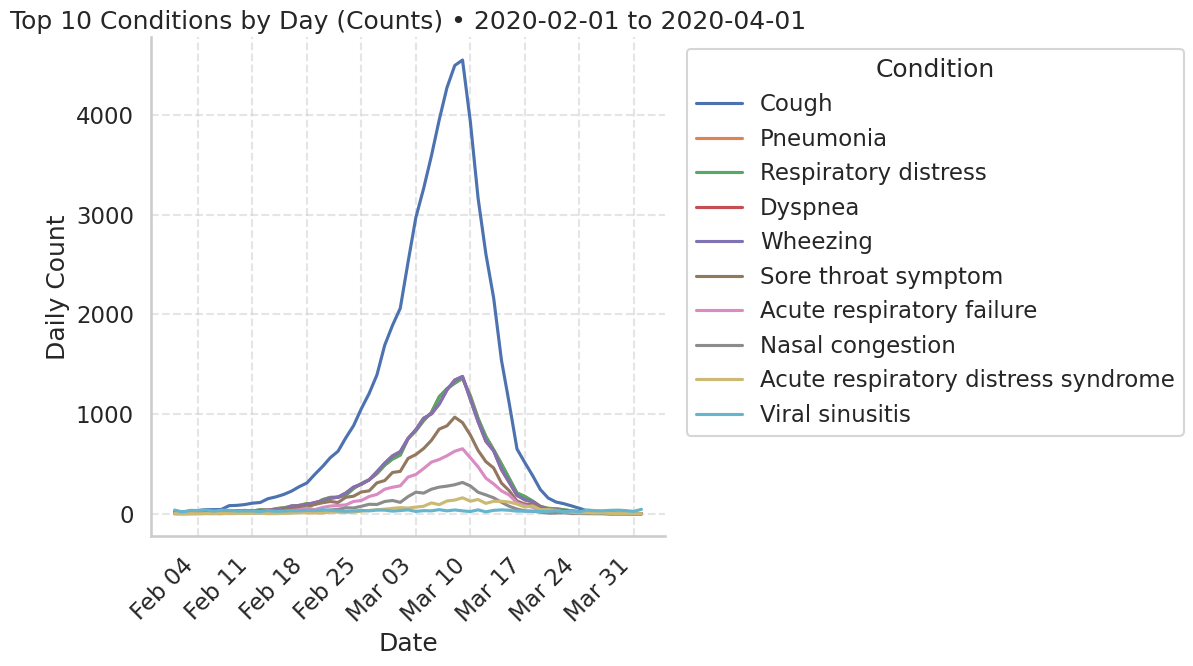

In [7]:
# ---------- 1) Multi-line chart (Seaborn lineplot) ----------
plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=daily, x="day", y="count", hue="condition_item")

ax.set(
    title=f"Top {TOP_K} Conditions by Day (Counts) • {START} to {END}",
    xlabel="Date",
    ylabel="Daily Count"
)

# Rotate and space out labels
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))   # one tick per week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))     # e.g. "Feb 01"
plt.xticks(rotation=45, ha='right')

# Lighten gridlines for clarity
sns.despine()
ax.grid(True, linestyle="--", alpha=0.5)

# Move legend outside for readability
ax.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()



### Visualization 2 — Stacked Area Plot (Percent Composition)

The stacked area chart shows how the *relative proportion* of each condition changes day by day.

Steps:
- Convert daily counts to wide format  
- Compute percent share for each condition per day  
- Plot as a stacked area chart  

This helps us understand shifts in the overall condition mix, even when total visit volume changes.


<Figure size 1200x700 with 0 Axes>

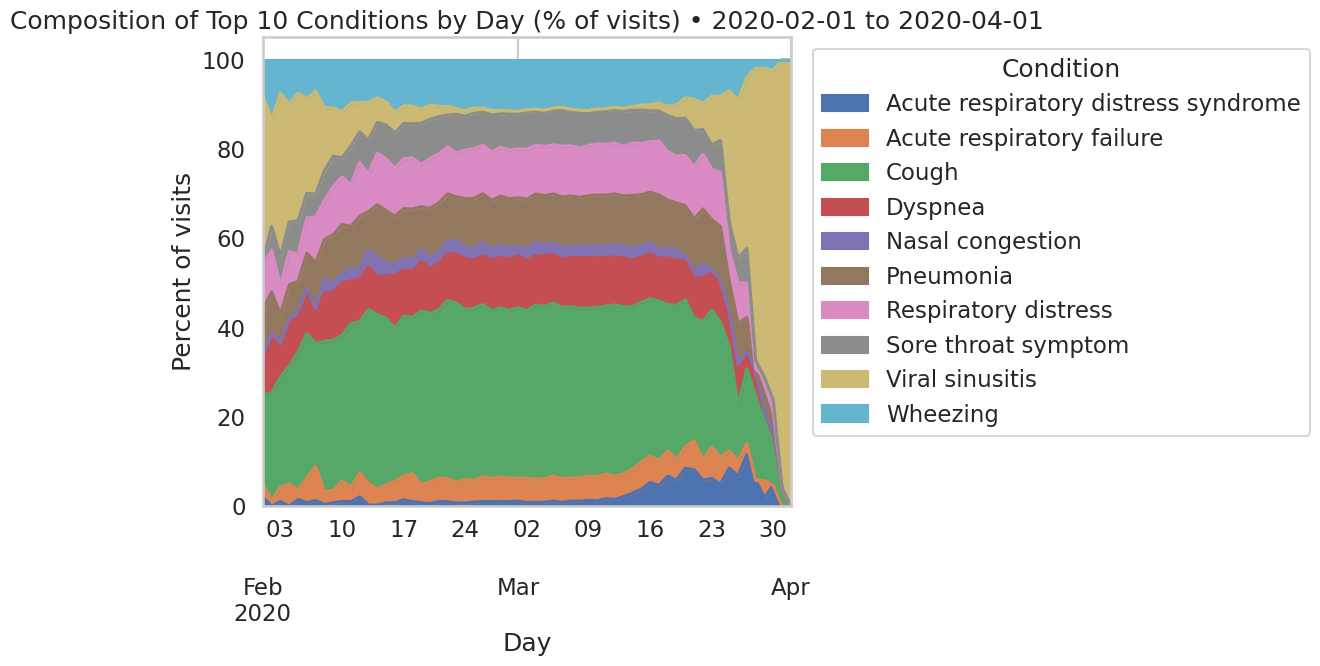

In [8]:
# ---------- 2) Stacked AREA (composition over time, % per day) ----------
wide = daily.pivot(index="day", columns="condition_item", values="count").sort_index()
share = wide.div(wide.sum(axis=1).replace(0, np.nan), axis=0).fillna(0) * 100

plt.figure(figsize=(12, 7))
share.plot(kind="area", stacked=True, figsize=(12, 7))
plt.title(f"Composition of Top {TOP_K} Conditions by Day (% of visits) • {START} to {END}")
plt.xlabel("Day")
plt.ylabel("Percent of visits")
plt.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



### Visualization 3 — Heatmap of Daily Condition Counts

The heatmap provides a compact comparison of all conditions across all days.

Details:
- Rows represent conditions  
- Columns represent days  
- Darker shades indicate higher counts  

We reduce the number of x-axis tick labels for readability and apply a smooth color palette.  
This visualization makes it easy to spot clusters, spikes, and patterns at a glance.


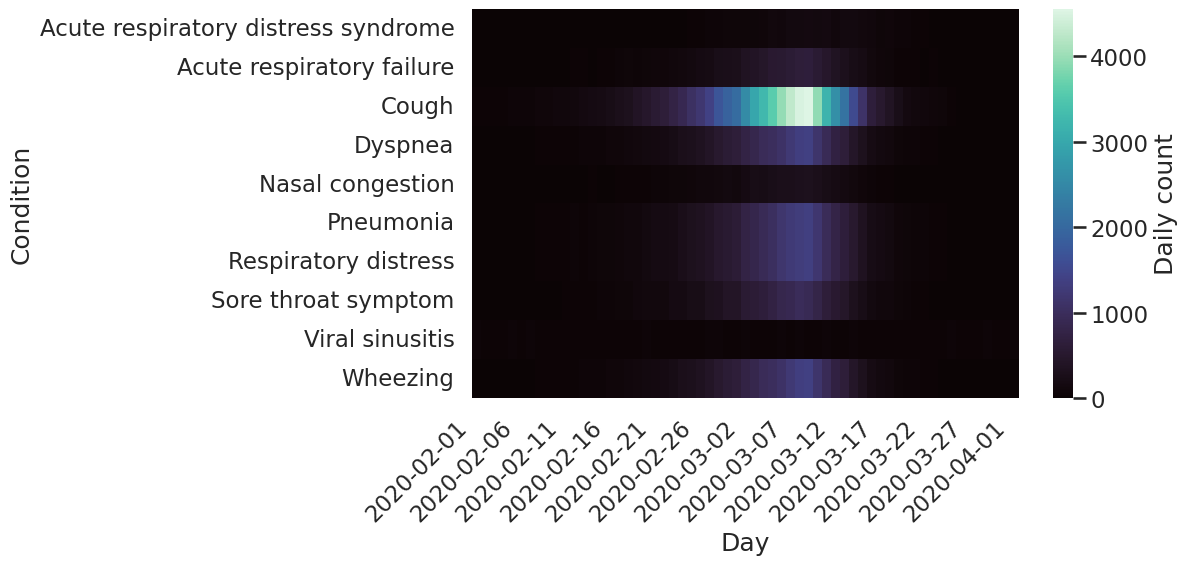

In [9]:
# ---------- 3) Heatmap (condition x day) ----------
heat = wide.T  # rows=condition, cols=day
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heat, cmap="mako", cbar_kws={"label": "Daily count"})
cols = heat.columns  # should be a DatetimeIndex or array-like of dates
labels = pd.Index(cols).astype(str).str[:10]   # keep 'YYYY-MM-DD'

# choose ~10–12 ticks, skipping the rest
n = len(cols)
step = max(1, n // 12)                         # show ~12 ticks (tweak as needed)
tick_idx = np.arange(0, n, step)

ax.set_xticks(tick_idx)                        # positions correspond to column indices
ax.set_xticklabels(labels[tick_idx], rotation=45, ha='right')

# optional polish
ax.set_xlabel("Day")
ax.set_ylabel("Condition")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()